# LEAF CLASSIFICATION PROJECT - Ensemble

**TEAM**  
Kaido  
Sander  
Egert

**Training models that can classify leafs**  
**LINK:** https://www.kaggle.com/competitions/leaf-classification/data

# Import models

In [1]:
# Import CNN, NN models
import tensorflow as tf
cnn = tf.keras.models.load_model("CNN_leaf")
nn = tf.keras.models.load_model("NN.keras")

In [2]:
# Import RF, KNN, LR, SVC models
from joblib import load
rf = load("leaf_model.pkl")
knn = load("knn_leaf_model.pkl")
lr = load("lr_leaf_model.pkl")
svc = load("svc_leaf_model.pkl")

# Import data

In [3]:
# Import data
import pandas as pd
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

(594, 256, 256)


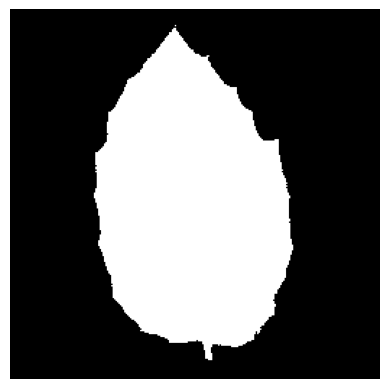

In [4]:
# Load in images and resize them to 256*256
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
# Load and resize images
input_folder = "images"
size = 256
images=[]
for i in range(1,len(os.listdir(input_folder))+1):
    img = Image.open(os.path.join(input_folder, f"{i}.jpg")).convert("1")

    # Resize proportionally
    w, h = img.size
    scale = size / max(w, h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    resized = img.resize((new_w, new_h), Image.LANCZOS)

    # Create a size x size black background
    output = Image.new("L", (size, size), 0)

    # Paste centered
    x = (size - new_w) // 2
    y = (size - new_h) // 2
    output.paste(resized, (x, y))

    # Add to array
    img_array = np.array(output)
    images.append(img_array)
images = np.array(images)
test_id = test["id"].to_numpy(dtype=int)-1
X_comp = images[test_id]
print(X_comp.shape)

plt.imshow(X_comp[0], cmap='gray')
plt.axis('off')
plt.show()

In [5]:
# Convert y to integers
from sklearn.preprocessing import LabelEncoder, StandardScaler
# Creates encoder and converts strings to integers
le = LabelEncoder()
y = le.fit_transform(train.species)
X = train.drop(['species'], axis = 1)

In [6]:
# Data split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, shuffle=True, random_state=1, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Predictions

In [7]:
# CNN probabilities
cnn_probs = cnn.predict(X_comp)

19/19 [==============================] - 5s 54ms/step


In [8]:
# NN probabilities
scaled  = scaler.transform(test)
nn_probs = nn.predict(scaled)

19/19 [==============================] - 0s 613us/step


In [9]:
# RF, KNN, LR, SVC probabilities
x_test = test.drop('id', axis=1) if 'id' in test.columns else test
rf_probs = rf.predict_proba(x_test)
knn_probs = knn.predict_proba(x_test)
lr_probs = lr.predict_proba(x_test)
svc_probs = svc.predict_proba(test)

# Ensemble

In [10]:
# Accuracy as weights
cnn_acc = 0.73
nn_acc = 0.97
svc_acc = 0.99
rf_acc = 0.97
knn_acc = 0.90
lr_acc = 0.92

In [11]:
# Weights for ensemble
weights = np.array([cnn_acc, nn_acc, svc_acc, rf_acc])#, knn_acc, lr_acc])
print(weights)
weights = weights / weights.sum() # Normalization
print(weights)

[0.73 0.97 0.99 0.97]
[0.19945355 0.26502732 0.2704918  0.26502732]


In [12]:
probs = [
    cnn_probs,
    nn_probs,
    svc_probs,
    rf_probs,
    # knn_probs,
    # lr_probs
]

In [13]:
# Ensemble
probs_stack = np.stack(probs)
ensemble_probs = np.tensordot(weights, probs_stack, axes=1)
ensemble_probs

array([[0.00171482, 0.0019372 , 0.00135754, ..., 0.00144385, 0.00349284,
        0.00239966],
       [0.01485427, 0.00165819, 0.00302216, ..., 0.0050256 , 0.00144895,
        0.00275982],
       [0.00271553, 0.48653723, 0.00174366, ..., 0.00151655, 0.00178684,
        0.00887087],
       ...,
       [0.00305147, 0.00242988, 0.00688108, ..., 0.00167554, 0.00723622,
        0.0050236 ],
       [0.00428754, 0.00190229, 0.00254528, ..., 0.00821225, 0.0047493 ,
        0.00285812],
       [0.00130739, 0.00190642, 0.00275696, ..., 0.00249046, 0.00561325,
        0.00316487]])

In [14]:
# Make submission df
submission = pd.DataFrame(ensemble_probs, columns=le.classes_)
submission.insert(0, 'id', (test_id+1))
submission

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
0,4,0.001715,0.001937,0.001358,0.001747,0.004051,0.002448,0.001221,0.014560,0.001773,...,0.001976,0.001710,0.007736,0.004812,0.002003,0.001633,0.001582,0.001444,0.003493,0.002400
1,7,0.014854,0.001658,0.003022,0.008969,0.000960,0.007076,0.003632,0.001278,0.001674,...,0.007388,0.002583,0.001552,0.001542,0.016886,0.004130,0.001916,0.005026,0.001449,0.002760
2,9,0.002716,0.486537,0.001744,0.002657,0.008741,0.002597,0.004286,0.002535,0.005049,...,0.002508,0.001516,0.002452,0.002365,0.001831,0.005562,0.003161,0.001517,0.001787,0.008871
3,12,0.004725,0.005463,0.001815,0.008003,0.001412,0.001660,0.005161,0.002253,0.003351,...,0.008597,0.004316,0.002755,0.002165,0.075798,0.022761,0.005445,0.001949,0.001850,0.004884
4,13,0.002839,0.016613,0.001422,0.002106,0.001503,0.001686,0.001796,0.004860,0.007191,...,0.005908,0.001464,0.020881,0.005791,0.003093,0.003643,0.006280,0.001754,0.001984,0.005756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,1576,0.003195,0.491091,0.004577,0.002750,0.005411,0.002203,0.004250,0.002448,0.005063,...,0.002583,0.001664,0.002597,0.002244,0.001710,0.005937,0.003931,0.001627,0.001803,0.006643
590,1577,0.003556,0.005546,0.001404,0.006441,0.001121,0.001462,0.012170,0.003907,0.019328,...,0.002274,0.001523,0.007611,0.002342,0.005736,0.008174,0.003689,0.001793,0.001502,0.008841
591,1579,0.003051,0.002430,0.006881,0.001776,0.004070,0.002953,0.094219,0.001613,0.017751,...,0.001575,0.001436,0.002468,0.002375,0.002313,0.001455,0.012156,0.001676,0.007236,0.005024
592,1580,0.004288,0.001902,0.002545,0.005443,0.001538,0.001852,0.002110,0.001869,0.001593,...,0.003280,0.031789,0.002337,0.003211,0.012149,0.002490,0.002060,0.008212,0.004749,0.002858


In [15]:
# Make biggest proba 1 and all other 0
prob_cols = submission.columns[1:]  # all probability columns
submission_max = submission.copy()
submission_max[prob_cols] = (submission[prob_cols].values == submission[prob_cols].values.max(axis=1, keepdims=True)).astype(int)
submission_max.describe()

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
count,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,...,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000
mean,780.673401,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.011785,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
std,465.646977,0.100079,0.100079,0.100079,0.100079,0.100079,0.100079,0.100079,0.100079,0.108006,...,0.100079,0.100079,0.100079,0.100079,0.100079,0.100079,0.100079,0.100079,0.100079,0.100079
min,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,368.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,774.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1184.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1583.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
# Save dataframes
submission.to_csv('ensemble_submission.csv', index=False)
submission_max.to_csv('ensemble_submission_max.csv', index=False)